# Project on Skin Cancer Recognition: Is the Skin Cancer Lesion Malignant or Benign?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Let's import all important libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import graphviz
import pydot
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Function of preprocessing of the dataset

In [ ]:
def pre_process(image_path):
    img = cv2.imread(image_path)
    img_to_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    labTran = cv2.cvtColor(img_to_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(labTran)
    claheTran = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = claheTran.apply(l)
    merged = cv2.merge((cl, a, b))
    imgNotResized = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    imgResized = cv2.resize(imgNotResized, (224, 224))
    return imgResized

### Let's pre-process the dataset (both train and test) with the progress on the output. In the end, convert the labels to binary (benign - 0, malignant - 1)

In [ ]:
trainingDirectory = '/content/drive/My Drive/data/train'
testingDirectory = '/content/drive/My Drive/data/test'
types = ['benign', 'malignant']
def imageLoadPre_Process(drct):
    imagePaths = []
    for tpe in types:
        tpePath = os.path.join(drct, tpe)
        for imgTitle in os.listdir(tpePath):
            imgPath = os.path.join(tpePath, imgTitle)
            imagePaths.append((imgPath, tpe))
    random.shuffle(imagePaths)
    imgs = []
    lbls = []
    origImgs = []
    totImgs = len(imagePaths)
    print(f"Quantity of images to preprocess: {totImgs}")
    for i, (imgPath, tpe) in enumerate(imagePaths):
        origImg = cv2.imread(imgPath)
        origImgRGB = cv2.cvtColor(origImg, cv2.COLOR_BGR2RGB)
        PPImg = pre_process(imgPath)
        origImgs.append(cv2.resize(origImgRGB, (224, 224)))
        imgs.append(PPImg)
        lbls.append(tpe)
        if (i + 1) % 100 == 0 or (i + 1) == totImgs:
            print(f"Processed {i + 1}/{totImgs} images")
    return np.array(imgs), np.array(lbls), np.array(origImgs)
print("Preprocessing trainings imgs...")
trainImgs, trainLbls, origTrainImgs = imageLoadPre_Process(trainingDirectory)
print("Preprocessing testing imgs...")
testImgs, testLbls, origTestImgs = imageLoadPre_Process(testingDirectory)
lblMap = { 'benign': 0, 'malignant': 1 }
trainLbls = np.array([lblMap[lbl] for lbl in trainLbls])
testLbls = np.array([lblMap[label] for label in testLbls])

Preprocessing trainings imgs...
Quantity of images to preprocess: 2609
Processed 100/2609 images
Processed 200/2609 images
Processed 300/2609 images
Processed 400/2609 images
Processed 500/2609 images
Processed 600/2609 images
Processed 700/2609 images
Processed 800/2609 images
Processed 900/2609 images
Processed 1000/2609 images
Processed 1100/2609 images
Processed 1200/2609 images
Processed 1300/2609 images
Processed 1400/2609 images
Processed 1500/2609 images
Processed 1600/2609 images
Processed 1700/2609 images
Processed 1800/2609 images
Processed 1900/2609 images
Processed 2000/2609 images
Processed 2100/2609 images
Processed 2200/2609 images
Processed 2300/2609 images
Processed 2400/2609 images
Processed 2500/2609 images
Processed 2600/2609 images
Processed 2609/2609 images
Preprocessing testing imgs...
Quantity of images to preprocess: 654
Processed 100/654 images
Processed 200/654 images
Processed 300/654 images
Processed 400/654 images
Processed 500/654 images
Processed 600/65

### After preprocessing, let us show the pipeline of the process with a random image from the train set

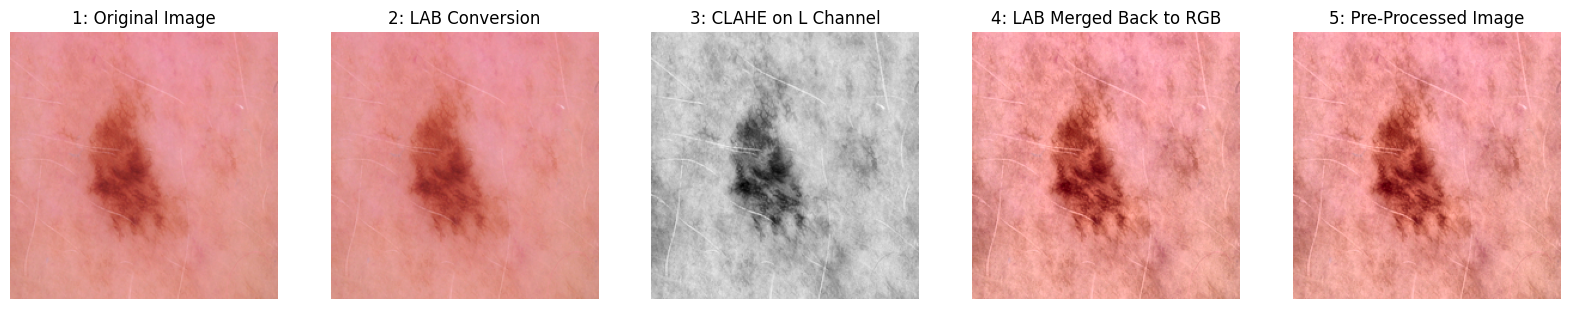

In [ ]:
smplInd = random.choice(range(len(trainImgs)))
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
imgRGB = origTrainImgs[smplInd]
axes[0].imshow(imgRGB)
axes[0].set_title("1: Original Image")
axes[0].axis('off')
labTran = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2LAB)
axes[1].imshow(cv2.cvtColor(labTran, cv2.COLOR_LAB2RGB))
axes[1].set_title("2: LAB Conversion")
axes[1].axis('off')
l, a, b = cv2.split(labTran)
claheTran = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl = claheTran.apply(l)
axes[2].imshow(cl, cmap='gray')
axes[2].set_title("3: CLAHE on L Channel")
axes[2].axis('off')
merged = cv2.merge((cl, a, b))
imgNotResized = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
axes[3].imshow(imgNotResized)
axes[3].set_title("4: LAB Merged Back to RGB")
axes[3].axis('off')
imgResized = cv2.resize(imgNotResized, (224, 224))
axes[4].imshow(imgResized)
axes[4].set_title("5: Pre-Processed Image")
axes[4].axis('off')
plt.show()

### Outline of the ImageDataGenerator for the Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode = "reflect",
    validation_split=0.2
)
train_generator = train_datagen.flow(trainImgs, trainLbls, batch_size=32, subset='training')
validation_generator = train_datagen.flow(trainImgs, trainLbls, batch_size=32, subset='validation')

### Let us run Data Augmentation for some examples to observe them

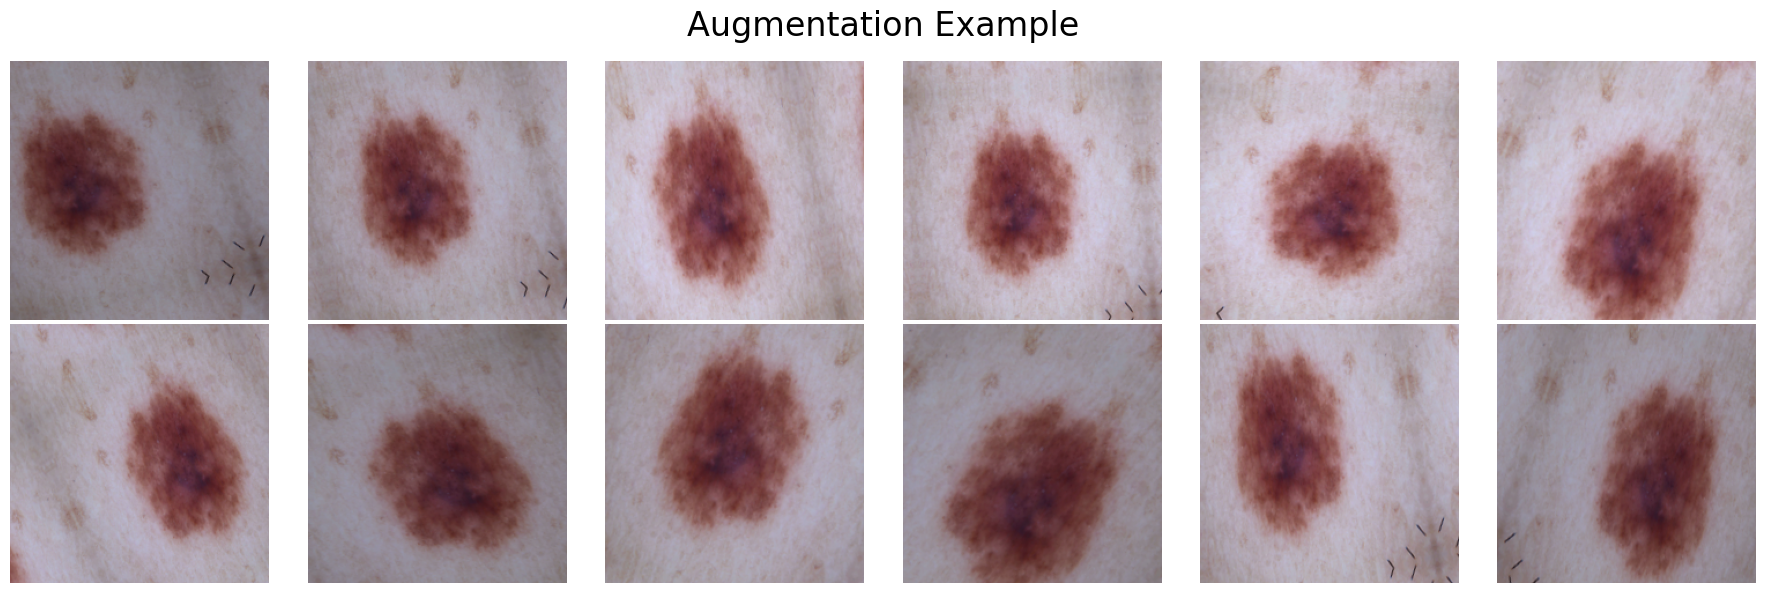

In [ ]:
smplInd = random.choice(range(len(origTrainImgs)))
imgRGB = origTrainImgs[smplInd]
numOfAugm= 12
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
fig.suptitle('Augmentation Example', fontsize=24)
for i in range(numOfAugm):
    r = i // 6
    c = i % 6
    augImg = np.expand_dims(imgRGB, axis=0)
    out = next(train_datagen.flow(augImg, batch_size=1))
    axes[r, c].imshow(out[0])
    axes[r, c].axis('off')
plt.tight_layout()
plt.show()

### As the Preprocessing and Data Augmentation parts are finished, let us train the proposed model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00000001, verbose=1)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                      

### Let us plot the model architecture for better visualisation

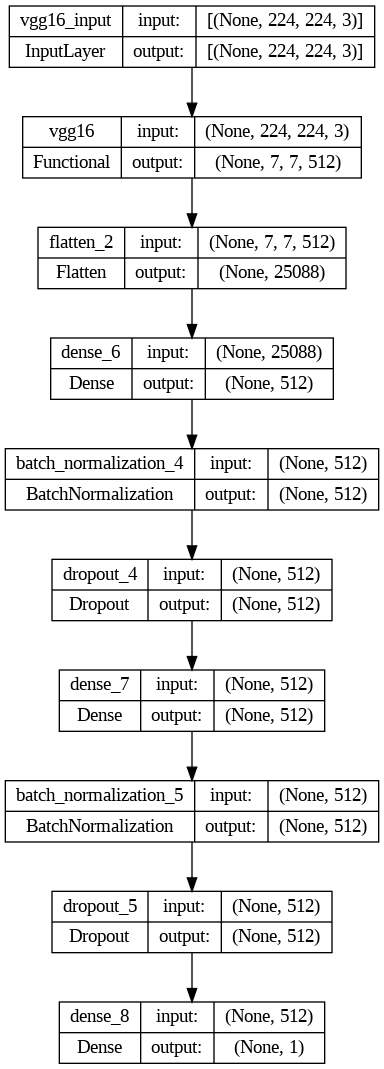

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Let us train the proposed model with 100 epochs (with Early Stopping)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/models/VGG16_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=100,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]
)

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.7328
Epoch 1: val_loss improved from inf to 1.25970, saving model to /content/drive/My Drive/models/VGG16_model.h5
66/66 [==============================] - 45s 649ms/step - loss: 0.6538 - accuracy: 0.7328 - val_loss: 1.2597 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.7783
Epoch 2: val_loss improved from 1.25970 to 0.79951, saving model to /content/drive/My Drive/models/VGG16_model.h5
66/66 [==============================] - 43s 659ms/step - loss: 0.5161 - accuracy: 0.7783 - val_loss: 0.7995 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.7893
Epoch 3: val_loss improved from 0.79951 to 0.55119, saving model to /content/drive/My Drive/models/VGG16_model.h5
66/66 [==============================] - 43s 648ms/step - loss: 0.4783 - accuracy: 0.78

### Let us show the trends of the training results of the proposed model (training/validation accuracy/loss)

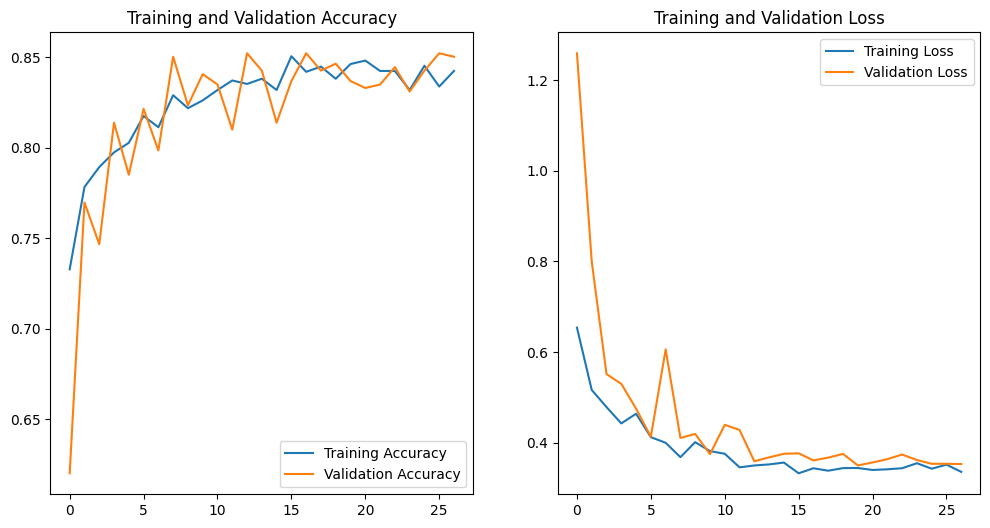

In [ ]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Let us show a practical assessment of the test dataset with the weights that were obtained during the training

In [ ]:
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.load_weights('/content/drive/My Drive/models/VGG16_model.h5')
print("Best model weights loaded successfully.")

Best model weights loaded successfully.


In [ ]:
val_loss, val_accuracy = model.evaluate(testImgs, testLbls)
print(f"Test Accuracy: {val_accuracy:.2f}")

21/21 [==============================] - 7s 303ms/step - loss: 11.2472 - accuracy: 0.7355
Test Accuracy: 0.74


### Let us show visualised results of the model that was trained during the work on the test data

In [ ]:
predictions = model.predict(testImgs)
lblsPrediction = (predictions > 0.5).astype(int)

21/21 [==============================] - 3s 125ms/step


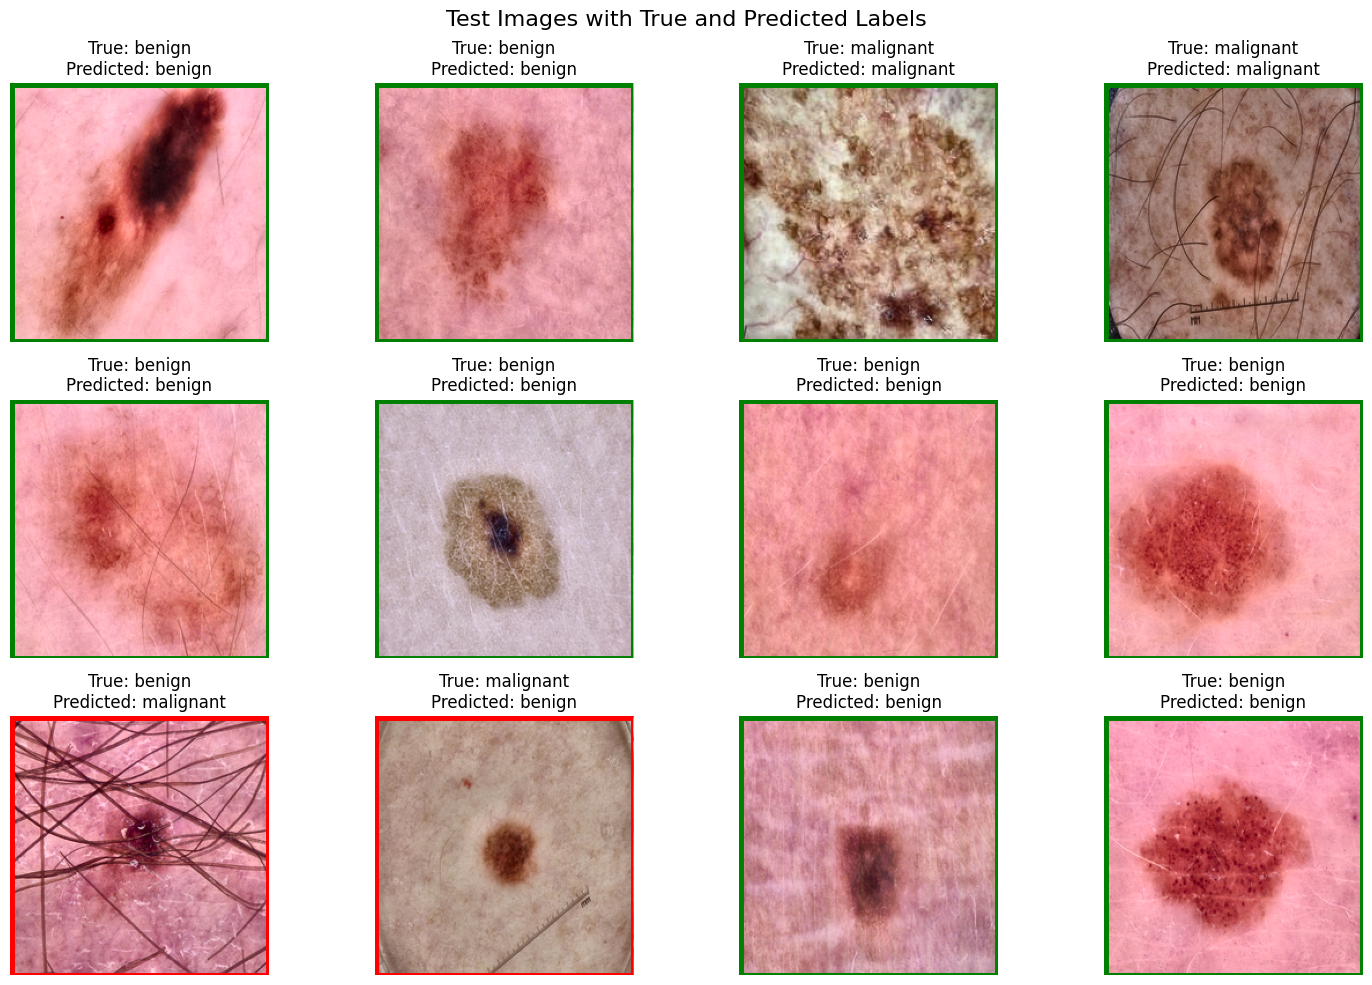

In [ ]:
mapping = {0: 'benign', 1: 'malignant'}
indices = np.random.choice(range(len(testImgs)), 12, replace=False)
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Test Images with True and Predicted Labels', fontsize=16)
for count, idx in enumerate(indices):
    ax = axes[count // 4, count % 4]
    ax.imshow(testImgs[idx])
    true_label = mapping[testLbls[idx]]
    predicted_label = mapping[lblsPrediction[idx][0]]
    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}')
    ax.axis('off')
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    rect = Rectangle((0, 0), testImgs[idx].shape[1], testImgs[idx].shape[0], linewidth=5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
plt.tight_layout()
plt.show()